In [548]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import datetime as DT

In [615]:
df = pd.read_csv('project_4_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            127 non-null    int64  
 1   flight_no            127 non-null    object 
 2   scheduled_departure  127 non-null    object 
 3   scheduled_arrival    127 non-null    object 
 4   estimate_time        127 non-null    object 
 5   actual_departure     127 non-null    object 
 6   actual_arrival       127 non-null    object 
 7   real_time            127 non-null    object 
 8   departure_airport    127 non-null    object 
 9   air_dep_name         127 non-null    object 
 10  city_dep             127 non-null    object 
 11  dep_long             127 non-null    float64
 12  dep_lat              127 non-null    float64
 13  arrival_airport      127 non-null    object 
 14  air_arr_name         127 non-null    object 
 15  city_arrival         127 non-null    obj

### Предобработака

In [616]:
# Заполним пропуски нулями
df = df.fillna(0)

In [617]:
# переведем даты в datetime
date_col = ['scheduled_departure','scheduled_arrival','actual_departure','actual_arrival']

for i in date_col:
    df[i] = df[i].apply(lambda x: pd.to_datetime(x))

In [618]:
# извлечем день и месяц для scheduled_departure
df['month_dep'] = df['scheduled_departure'].dt.month
df['day_dep'] = df['scheduled_departure'].dt.day
df['day_name'] = df['scheduled_departure'].dt.weekday

In [619]:
# переведем real_time (время полета) в минуты
df['real_time'] = pd.to_datetime(df['real_time']).dt.hour*60 + pd.to_datetime(df['real_time']).dt.minute

### Предварительный анализ данных

Посмотрим сколько рейсов летает из Анапы

In [620]:
df.departure_airport.value_counts()

AAQ    127
Name: departure_airport, dtype: int64

In [621]:
df['scheduled_departure'].dt.month.max()

2

Имеем данные за январь и февраль 2017

Всего рейсов в январе: 67


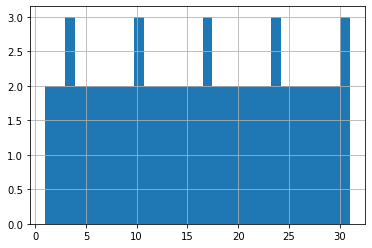

In [622]:
# Посмотрим на распределение полетов по дням в январе
df.query('month_dep == 1').day_dep.hist(bins=31)
print('Всего рейсов в январе:',sum(df.query('month_dep == 1').day_dep.value_counts()))

Всего рейсов в феврале: 60


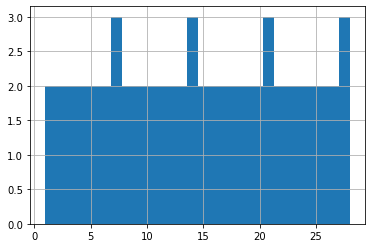

In [623]:
# Посмотрим на распределение полетов по дням в феврале
df.query('month_dep == 2').day_dep.hist(bins=28)
print('Всего рейсов в феврале:',sum(df.query('month_dep == 2').day_dep.value_counts()))

In [624]:
# посмотрим на заполняемость рейсов
df['total_in_flight'] = df.bus_seats + df.com_seats + df.eco_seats
df['empty_bus'] = df.bussines_seats - df.bus_seats
df['empty_com'] = df.comfort_seats - df.com_seats
df['empty_eco'] = df.economy_seats - df.eco_seats
df['occupancy_fl'] = df['total_in_flight']/df['total_seats']

<AxesSubplot:>

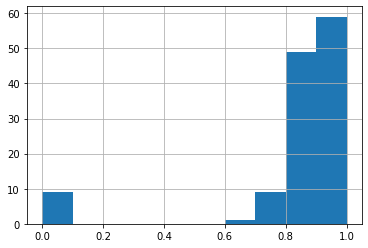

In [625]:
df['occupancy_fl'].hist()

In [626]:
# посмотрим сколько рейсов имеет заполняемость ниже 80%
df.query('occupancy_fl < 0.8').shape

(19, 40)

In [627]:
# посмотрим по каким направлениям следуют рейсы
df.air_arr_name.value_counts()

Sheremetyevo International Airport    59
Belgorod International Airport        59
Spichenkovo Airport                    9
Name: air_arr_name, dtype: int64

Промежуточный итог: Рейсы в январе и феврале осуществляются регулярно, однако практически 10% от выполеных рейсов имеют заполняемость ниже 80%

### Сбор дополнительных данных

Для примерной оценки прибыльности рейса, соберем дополнительные данные:
- стоимость авиа топлива на 2017 год по месяцам и аэропортам
- средний расход топлива (кг/час) по моделям самолета

In [628]:
df.model.value_counts()

Boeing 737-300         68
Sukhoi Superjet-100    59
Name: model, dtype: int64

Основываясь на расходе топлива по конкретной модели самолета, можем вычислить примерный расход топлива на каждый рейс.<br>
Однако, судить о прибыльности или убыточности рейса этой информации не достаточно. <br>
Поэтому возьмем информацию из внешних источников о структуре операционных затрат авиакомпаний за первую половину 2017.<br>
Расчитаем относительные пределы прибыльности рейсов основываясь на этих данных.

In [629]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.aex.ru/imgupl/d2694_p19.png", width=1000, height=100)

Возьмем рейсы с заполняемостью 100% и расчитаем сумму ниже которой будем считать рейс малоприбыльным.

In [630]:
df.query('occupancy_fl == 1').groupby('total_amount_flight')[['city_arrival','model','total_seats']].max()

,city_arrival,model,total_seats
total_amount_flight,,,
765300.0,Belgorod,Sukhoi Superjet-100,97
1886000.0,Moscow,Boeing 737-300,130


In [631]:
df['profit_margin'] = df.model.apply(lambda x: 1886000.0*0.81 if x=='Boeing 737-300' else 765300.0*0.81 if x=='Sukhoi Superjet-100' else 0)

In [632]:
df['profit'] = df['total_amount_flight'] - df['profit_margin']

In [633]:
# создадим столбец с расходами на топливо по каждому рейсу
df['fuel_consum_rub'] = 0
df.loc[(df.model == 'Boeing 737-300') & (df.month_dep == 1),
       'fuel_consum_rub'] = df.real_time*2600/60*41435*(1+0.18)/1000
df.loc[(df.model == 'Boeing 737-300') & (df.month_dep == 2),
       'fuel_consum_rub'] = df.real_time*2600/60*39553*(1+0.18)/1000

df.loc[(df.model == 'Sukhoi Superjet-100') & (df.month_dep == 1),
       'fuel_consum_rub'] = df.real_time*1700/60*41435*(1+0.18)/1000
df.loc[(df.model == 'Sukhoi Superjet-100') & (df.month_dep == 2),
       'fuel_consum_rub'] = df.real_time*1700/60*39553*(1+0.18)/1000

0.15155290891750117

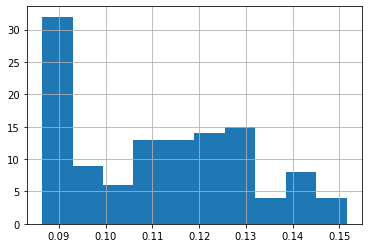

In [634]:
# Доля расходов на топливо
(df['fuel_consum_rub']/df.loc[df.total_amount_flight > 0,'total_amount_flight']).hist()
(df['fuel_consum_rub']/df.loc[df.total_amount_flight > 0,'total_amount_flight']).max()

In [635]:
# Процент расходов на топливо от выручки
df['fuel_ratio']=df['fuel_consum_rub']/df.loc[df.total_amount_flight > 0,'total_amount_flight']

In [636]:
# Процент заполняемости в бизнесс классе
df['bus_occup'] = df['bus_seats']/df['bussines_seats']

In [637]:
# Процент заполняемости в эконом классе
df['eco_occup'] = df['eco_seats']/df['economy_seats']

In [638]:
df = df.drop(columns=['com_seats', 'comfort_seats','com_amount','scheduled_departure','scheduled_arrival',
                     'estimate_time','actual_departure','actual_arrival','dep_long','dep_lat','departure_airport',
                     'air_dep_name','city_dep','arr_long','arr_lat','empty_com','range'])

In [639]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            127 non-null    int64  
 1   flight_no            127 non-null    object 
 2   real_time            127 non-null    int64  
 3   arrival_airport      127 non-null    object 
 4   air_arr_name         127 non-null    object 
 5   city_arrival         127 non-null    object 
 6   bus_seats            127 non-null    float64
 7   eco_seats            127 non-null    float64
 8   bus_amount           127 non-null    float64
 9   eco_amount           127 non-null    float64
 10  total_amount_flight  127 non-null    float64
 11  model                127 non-null    object 
 12  aircraft_code        127 non-null    object 
 13  bussines_seats       127 non-null    int64  
 14  economy_seats        127 non-null    int64  
 15  total_seats          127 non-null    int

Выделим проблемные рейсы (рейсы у которых предел прибыльности выше выручки)

In [640]:
df_problem = df.query('profit_margin > total_amount_flight')


Все рейсы выделим в отделбный датасет

In [801]:
# Оставим интересующие нас данные
df_final = df[['flight_id', 'flight_no', 'month_dep', 'day_dep','day_name', 'real_time', 'arrival_airport',
               'city_arrival','bus_seats','bus_occup', 'eco_seats','eco_occup', 'model', 'total_seats', 
               'total_in_flight', 'empty_bus', 'empty_eco', 'occupancy_fl','bus_amount','eco_amount','fuel_consum_rub',
               'fuel_ratio','profit_margin','profit','total_amount_flight']]

In [802]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            127 non-null    int64  
 1   flight_no            127 non-null    object 
 2   month_dep            127 non-null    int64  
 3   day_dep              127 non-null    int64  
 4   day_name             127 non-null    int64  
 5   real_time            127 non-null    int64  
 6   arrival_airport      127 non-null    object 
 7   city_arrival         127 non-null    object 
 8   bus_seats            127 non-null    float64
 9   bus_occup            127 non-null    float64
 10  eco_seats            127 non-null    float64
 11  eco_occup            127 non-null    float64
 12  model                127 non-null    object 
 13  total_seats          127 non-null    int64  
 14  total_in_flight      127 non-null    float64
 15  empty_bus            127 non-null    flo

# Анализ рейсов

Проанализируем рейсы по направлениям, мы имеем всего три направления: Москва, Белгород, Новокузнецк

In [643]:
def per_city(data):
    for i in df_final.city_arrival.unique():
        print('Город прилета :', i)
        df_help = df_final[df_final['city_arrival'] == i]
        print('Совершенных рейсов :', len(df_help['flight_no']))
        print('Модель самолета :', df_help['model'].unique())
        print('Кол-во перевезенных пассажиров :', df_help['total_in_flight'].sum())
        print('Среднее время полета :', df_help['real_time'].mean())
        print('Выручка за янв-февр :',round(df_help['total_amount_flight'].sum(),2))
        print('Средняя выручка на одного пассажира :',round(df_help['total_amount_flight'].sum()/df_help['total_in_flight'].sum(),2))
        print(' ')
        print('Рейсы в январе :', len(df_help.loc[df['month_dep']==1]))
        print('Средняя заполняемость в январе :', df_help.loc[df['month_dep']==1,'occupancy_fl'].mean())
        print('Выручка в январе :', sum(df_help.loc[df['month_dep']==1,'total_amount_flight']))
        print(' ')
        print('Рейсы в феврале :', len(df_help.loc[df['month_dep']==2]))
        print('Средняя заполняемость в феврале :', df_help.loc[df['month_dep']==2,'occupancy_fl'].mean())
        print('Выручка в феврале :', sum(df_help.loc[df['month_dep']==2,'total_amount_flight']))
        print(' ------------ ')
        print(' ')

In [644]:
per_city(df_final)

Город прилета : Moscow
Совершенных рейсов : 59
Модель самолета : ['Boeing 737-300']
Кол-во перевезенных пассажиров : 6674.0
Среднее время полета : 99.83050847457628
Выручка за янв-февр : 96912000.0
Средняя выручка на одного пассажира : 14520.83
 
Рейсы в январе : 31
Средняя заполняемость в январе : 0.8761786600496281
Выручка в январе : 51274600.0
 
Рейсы в феврале : 28
Средняя заполняемость в феврале : 0.8634615384615384
Выручка в феврале : 45637400.0
 ------------ 
 
Город прилета : Belgorod
Совершенных рейсов : 59
Модель самолета : ['Sukhoi Superjet-100']
Кол-во перевезенных пассажиров : 5321.0
Среднее время полета : 50.08474576271186
Выручка за янв-февр : 41915700.0
Средняя выручка на одного пассажира : 7877.41
 
Рейсы в январе : 31
Средняя заполняемость в январе : 0.9308280678417028
Выручка в январе : 22067100.0
 
Рейсы в феврале : 28
Средняя заполняемость в феврале : 0.9285714285714287
Выручка в феврале : 19848600.0
 ------------ 
 
Город прилета : Novokuznetsk
Совершенных рейсов 

<ipython-input-643-84ce608ad641>:10: RuntimeWarning: invalid value encountered in double_scalars
  print('Средняя выручка на одного пассажира :',round(df_help['total_amount_flight'].sum()/df_help['total_in_flight'].sum(),2))


- Как мы видим по рейсам в Новокузнецк мы не имеем данных. Анализировать это направление мы не будем.

In [816]:
# Удалим строки по направлению Новокузнецк
df_final = df_final.drop(df_final[df_final['city_arrival'] == 'Novokuznetsk'].index)

In [817]:
df_final

,flight_id,flight_no,month_dep,day_dep,day_name,real_time,arrival_airport,city_arrival,bus_seats,bus_occup,...,empty_bus,empty_eco,occupancy_fl,bus_amount,eco_amount,fuel_consum_rub,fuel_ratio,profit_margin,profit,total_amount_flight
0,136119,PG0252,1,3,1,101,SVO,Moscow,11.0,0.916667,...,1.0,16.0,0.869231,402600.0,1250400.0,213989.676333,0.129455,1527660.0,125340.0,1653000.0
1,136120,PG0252,2,24,4,99,SVO,Moscow,11.0,0.916667,...,1.0,20.0,0.838462,402600.0,1202800.0,200225.196600,0.124720,1527660.0,77740.0,1605400.0
2,136122,PG0252,1,8,6,100,SVO,Moscow,10.0,0.833333,...,2.0,31.0,0.746154,366000.0,1065000.0,211870.966667,0.148058,1527660.0,-96660.0,1431000.0
3,136130,PG0252,2,13,0,99,SVO,Moscow,10.0,0.833333,...,2.0,21.0,0.823077,366000.0,1190600.0,200225.196600,0.128630,1527660.0,28940.0,1556600.0
4,136131,PG0252,1,28,5,99,SVO,Moscow,12.0,1.000000,...,0.0,6.0,0.953846,439200.0,1373600.0,209752.257000,0.115706,1527660.0,285140.0,1812800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,136936,PG0480,1,2,0,50,EGO,Belgorod,9.0,0.750000,...,3.0,12.0,0.845361,170100.0,462300.0,69265.508333,0.109528,619893.0,12507.0,632400.0
114,136937,PG0480,1,3,1,50,EGO,Belgorod,9.0,0.750000,...,3.0,13.0,0.835052,170100.0,456000.0,69265.508333,0.110630,619893.0,6207.0,626100.0
115,136951,PG0480,2,2,3,49,EGO,Belgorod,12.0,1.000000,...,0.0,7.0,0.927835,226800.0,493800.0,64797.043033,0.089921,619893.0,100707.0,720600.0
116,136953,PG0480,2,27,0,50,EGO,Belgorod,12.0,1.000000,...,0.0,0.0,1.000000,226800.0,538500.0,66119.431667,0.086397,619893.0,145407.0,765300.0


Посмотрим какие показатели влияют на прибыль и выручку. Очевидно, что это заполняемость рейса, но возможно, увидим другие закономерности

<AxesSubplot:>

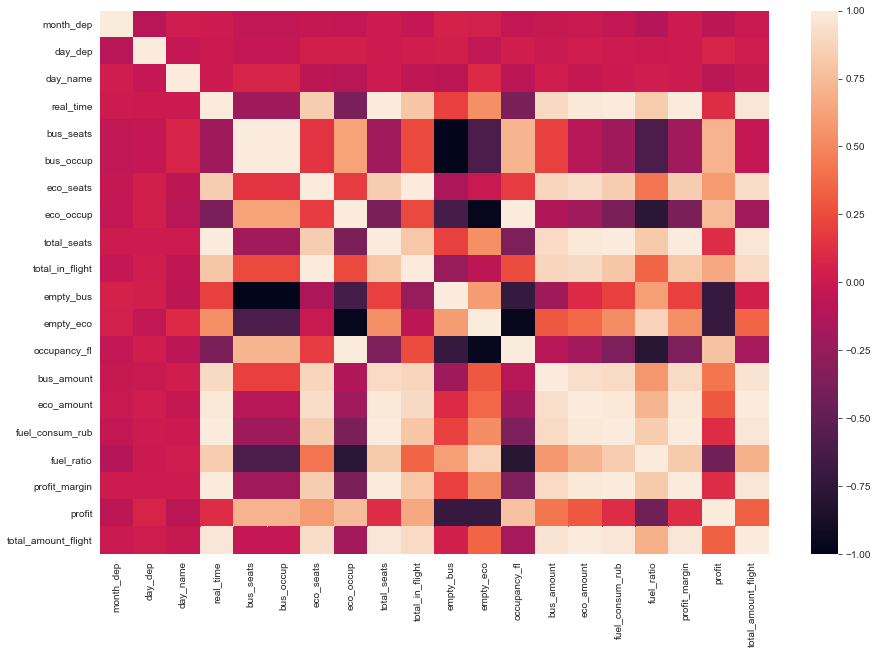

In [841]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df_final.drop(['flight_id','flight_no'], axis=1).corr())

In [821]:
df_corr = pd.DataFrame(df_final.corr())
help_list=[]
for i in df_corr:
    for n in df_corr[i]:
        if df_corr.index[df_corr[i]== n][0] != i:
            if n> 0.6 or n<-0.6:
                if n not in help_list:
                    help_list.append(n)
                    print('Row/Col :','\n',df_corr.index[df_corr[i]== n][0],'/',i,'\n', n,'\n')

Row/Col : 
 real_time / flight_id 
 -0.8992554002259235 

Row/Col : 
 eco_seats / flight_id 
 -0.7341700340796758 

Row/Col : 
 total_seats / flight_id 
 -0.900023146619479 

Row/Col : 
 total_in_flight / flight_id 
 -0.7059649316036918 

Row/Col : 
 bus_amount / flight_id 
 -0.831428131582771 

Row/Col : 
 eco_amount / flight_id 
 -0.8716991487049094 

Row/Col : 
 fuel_consum_rub / flight_id 
 -0.8986479127198986 

Row/Col : 
 fuel_ratio / flight_id 
 -0.7515317320424827 

Row/Col : 
 profit_margin / flight_id 
 -0.9000231466194782 

Row/Col : 
 total_amount_flight / flight_id 
 -0.872854743289553 

Row/Col : 
 eco_seats / real_time 
 0.838841237574015 

Row/Col : 
 total_seats / real_time 
 0.9994464924750937 

Row/Col : 
 total_in_flight / real_time 
 0.8028972691075213 

Row/Col : 
 bus_amount / real_time 
 0.9057372747998053 

Row/Col : 
 eco_amount / real_time 
 0.9784983134952807 

Row/Col : 
 fuel_consum_rub / real_time 
 0.9985729539564789 

Row/Col : 
 fuel_ratio / real_time 

In [818]:
df_corr = pd.DataFrame(df_final.corr())
for n in df_corr['profit']:
    if n> 0.4 or n<-0.4:
        print('profit /',df_corr.index[df_corr['profit']== n][0],'\n', n,'\n')

profit / bus_seats 
 0.7094534825127207 

profit / bus_occup 
 0.7094534825127227 

profit / eco_seats 
 0.5919172114708372 

profit / eco_occup 
 0.7565368171997818 

profit / total_in_flight 
 0.6500682795980729 

profit / empty_bus 
 -0.7094534825127208 

profit / empty_eco 
 -0.7094306605567511 

profit / occupancy_fl 
 0.7851451655863267 

profit / bus_amount 
 0.4246094726825774 

profit / fuel_ratio 
 -0.41774175586398116 

profit / profit 
 1.0 



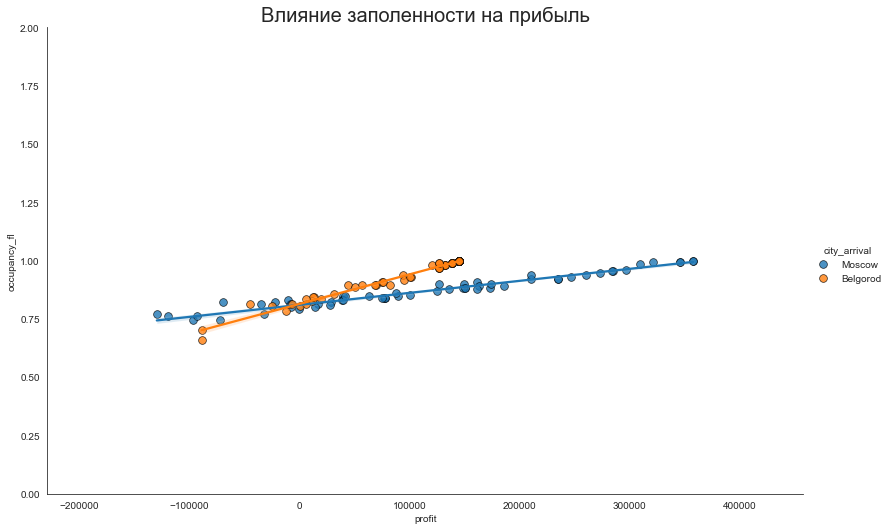

In [836]:
sns.set_style("white")
gridobj = sns.lmplot(x="profit", y="occupancy_fl", data=df_final, hue = 'city_arrival',
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

# Decorations
gridobj.set(xlim=(df_final.profit.min()-100000, df_final.profit.max()+100000), ylim=(0, 2))
plt.title("Влияние заполенности на прибыль", fontsize=20)
plt.show()

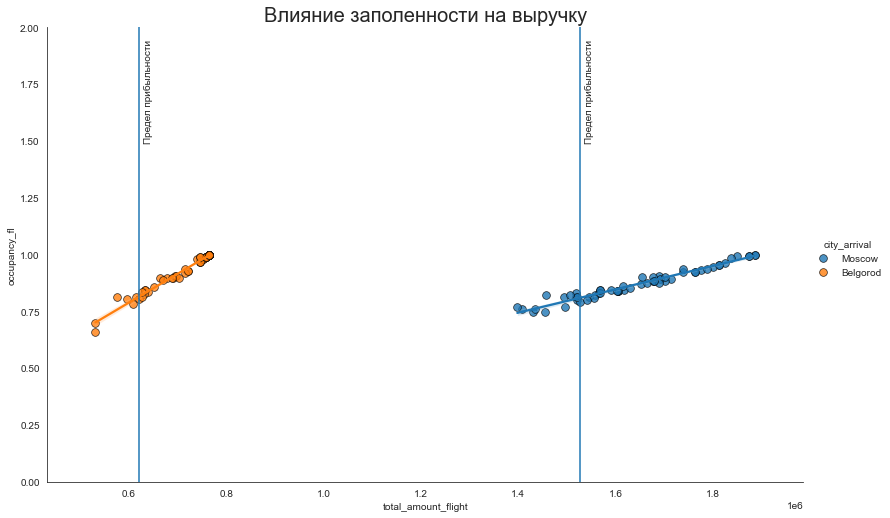

In [856]:
sns.set_style("white")
gridobj = sns.lmplot(x="total_amount_flight", y="occupancy_fl",hue = 'city_arrival', data=df_final, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

# Decorations
gridobj.set(xlim=(df_final.total_amount_flight.min()-100000, df_final.total_amount_flight.max()+100000), ylim=(0, 2))
plt.title("Влияние заполенности на выручку", fontsize=20)
plt.axvline(z)
plt.text(z+10000,1.5,'Предел прибыльности',rotation=90)
plt.axvline(z1)
plt.text(z1+10000,1.5,'Предел прибыльности',rotation=90)
plt.show()

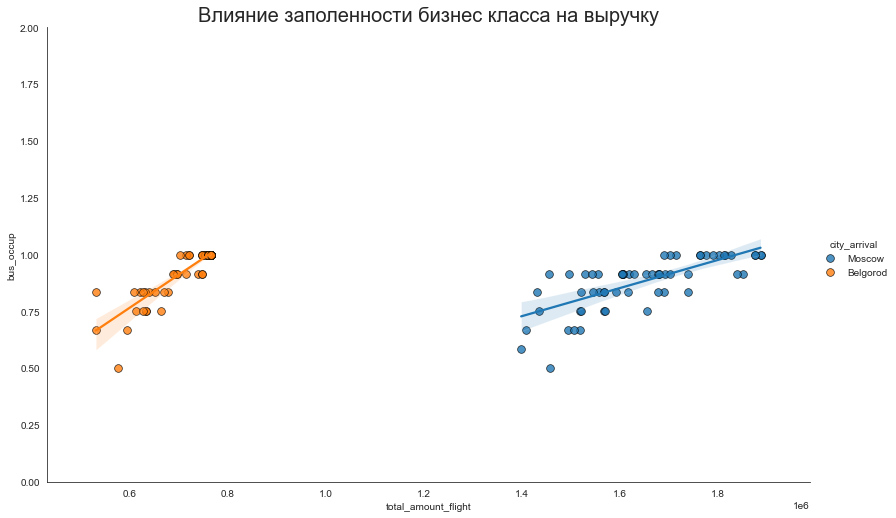

In [839]:
sns.set_style("white")
gridobj = sns.lmplot(x="total_amount_flight", y="bus_occup",hue = 'city_arrival', data=df_final, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

# Decorations
gridobj.set(xlim=(df_final.total_amount_flight.min()-100000, df_final.total_amount_flight.max()+100000), ylim=(0, 2))
plt.title("Влияние заполенности бизнес класса на выручку", fontsize=20)
plt.show()

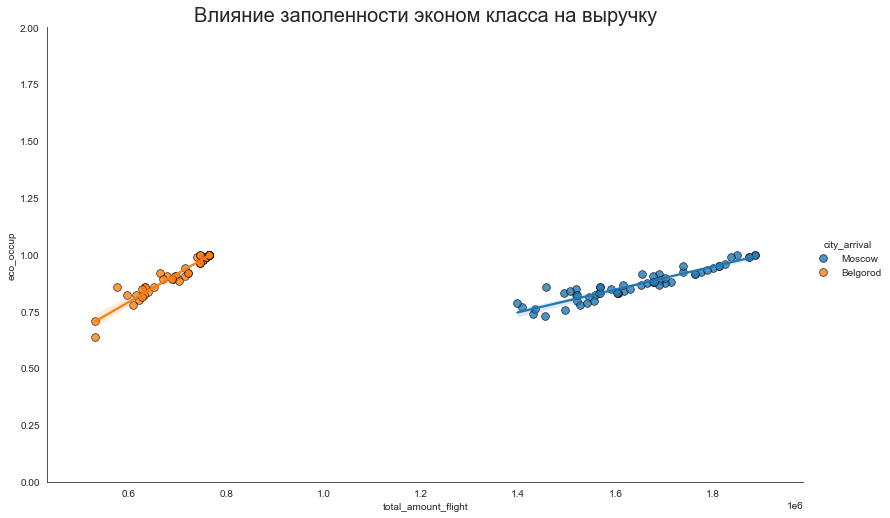

In [857]:
sns.set_style("white")
gridobj = sns.lmplot(x="total_amount_flight", y="eco_occup", hue='city_arrival', data=df_final,
                     height=7, aspect=1.6, robust=True, palette='tab10',
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))
z = df_final[df_final['city_arrival'] == 'Moscow'].profit_margin.max()
z1 = df_final[df_final['city_arrival'] == 'Belgorod'].profit_margin.max()
# Decorations
gridobj.set(xlim=(df_final.total_amount_flight.min()-100000,
                  df_final.total_amount_flight.max()+100000), ylim=(0, 2))
plt.title("Влияние заполенности эконом класса на выручку", fontsize=20)
plt.show()

In [820]:
df_final

,flight_id,flight_no,month_dep,day_dep,day_name,real_time,arrival_airport,city_arrival,bus_seats,bus_occup,...,empty_bus,empty_eco,occupancy_fl,bus_amount,eco_amount,fuel_consum_rub,fuel_ratio,profit_margin,profit,total_amount_flight
0,136119,PG0252,1,3,1,101,SVO,Moscow,11.0,0.916667,...,1.0,16.0,0.869231,402600.0,1250400.0,213989.676333,0.129455,1527660.0,125340.0,1653000.0
1,136120,PG0252,2,24,4,99,SVO,Moscow,11.0,0.916667,...,1.0,20.0,0.838462,402600.0,1202800.0,200225.196600,0.124720,1527660.0,77740.0,1605400.0
2,136122,PG0252,1,8,6,100,SVO,Moscow,10.0,0.833333,...,2.0,31.0,0.746154,366000.0,1065000.0,211870.966667,0.148058,1527660.0,-96660.0,1431000.0
3,136130,PG0252,2,13,0,99,SVO,Moscow,10.0,0.833333,...,2.0,21.0,0.823077,366000.0,1190600.0,200225.196600,0.128630,1527660.0,28940.0,1556600.0
4,136131,PG0252,1,28,5,99,SVO,Moscow,12.0,1.000000,...,0.0,6.0,0.953846,439200.0,1373600.0,209752.257000,0.115706,1527660.0,285140.0,1812800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,136936,PG0480,1,2,0,50,EGO,Belgorod,9.0,0.750000,...,3.0,12.0,0.845361,170100.0,462300.0,69265.508333,0.109528,619893.0,12507.0,632400.0
114,136937,PG0480,1,3,1,50,EGO,Belgorod,9.0,0.750000,...,3.0,13.0,0.835052,170100.0,456000.0,69265.508333,0.110630,619893.0,6207.0,626100.0
115,136951,PG0480,2,2,3,49,EGO,Belgorod,12.0,1.000000,...,0.0,7.0,0.927835,226800.0,493800.0,64797.043033,0.089921,619893.0,100707.0,720600.0
116,136953,PG0480,2,27,0,50,EGO,Belgorod,12.0,1.000000,...,0.0,0.0,1.000000,226800.0,538500.0,66119.431667,0.086397,619893.0,145407.0,765300.0


Особых открытий не последовало, но можно отметить, затраты на авиа топливо. <br> Также можно заметить более выраженную зависимость выручки и прибыли по направлению Белгород

Выручка по направлениям за январь-февраль 2017


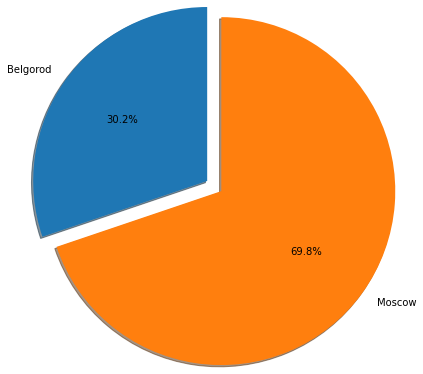

In [597]:
print('Выручка по направлениям за январь-февраль 2017')
labels = list(df_final.groupby('city_arrival')['total_amount_flight'].sum().index)
sizes = df_final.groupby('city_arrival')['total_amount_flight'].sum()
explode = (0.1, 0.1) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,radius=2)
plt.show()

Прибыль по направлениям за январь-февраль 2017


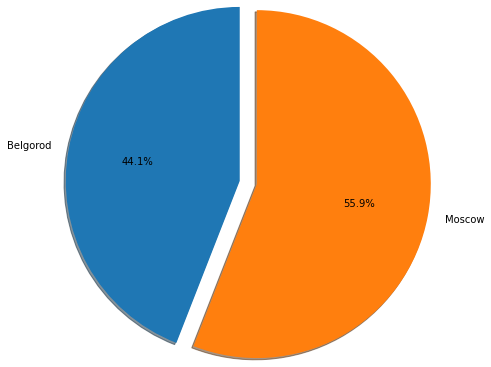

In [654]:
print('Прибыль по направлениям за январь-февраль 2017')
labels = list(df_final.groupby('city_arrival')['profit'].sum().index)
sizes = df_final.groupby('city_arrival')['profit'].sum()
explode = (0.1, 0.1) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,radius=2)
plt.show()

# Рассмотрим направления Москва и Белгород

## Москва

In [655]:
df_m = df_final[df_final['city_arrival'] == 'Moscow']

Среднее кол-во пассажиров на рейс за январь : 114
Рейсы с заполняемостью ниже среднего в январе 15
Среднее кол-во пассажиров на рейс за февраль : 112
Рейсы с заполняемостью ниже среднего в феврале 16


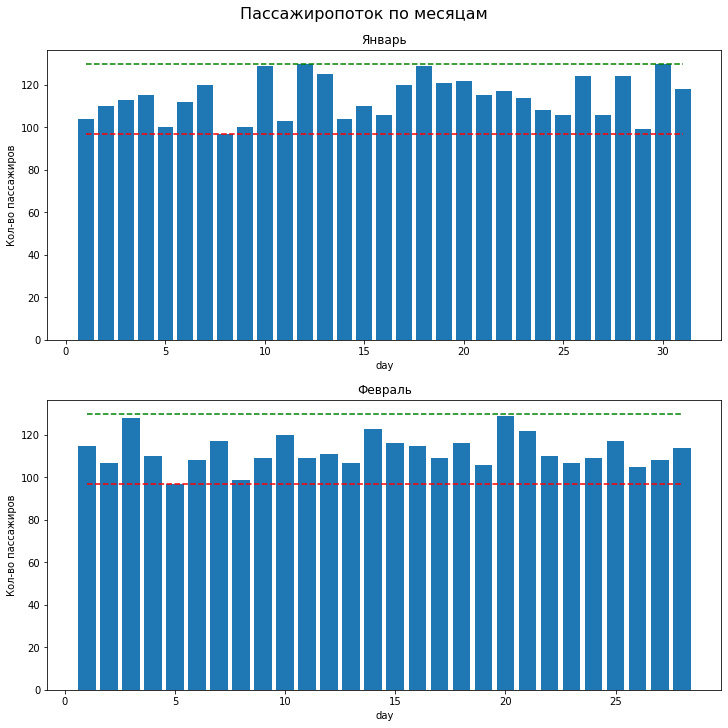

In [689]:
x = range(1,32)
y = df_m.query('month_dep == 1').sort_values(by='day_dep')['total_in_flight']
x1 = range(1,29)
y1 = df_m.query('month_dep == 2').sort_values(by='day_dep')['total_in_flight']
t = df['total_seats'].max()
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharey=True,figsize=(10, 10))
ax1.bar(x, y)
ax1.set_title('Январь')
ax1.set_xlabel('day')
ax1.set_ylabel('Кол-во пассажиров')
ax1.plot(x,[y.min() for i in x], '--',color='r')
ax1.plot(x,[t for i in x], '--',color='g')
ax2.bar(x1, y1)
ax2.set_xlabel('day')
ax2.set_title('Февраль')
ax2.set_ylabel('Кол-во пассажиров')
ax2.plot(x1,[y1.min() for i in x1], '--',color='r')
ax2.plot(x1,[t for i in x1], '--',color='g')
fig.suptitle('Пассажиропоток по месяцам', fontsize=16)
print('Среднее кол-во пассажиров на рейс за январь :',
      round(df_m.query('month_dep == 1').sort_values(by='day_dep')['total_in_flight'].mean()))
print('Рейсы с заполняемостью ниже среднего в январе', df_m.query(
    'month_dep == 1 & total_in_flight < 114')['flight_id'].nunique())
print('Среднее кол-во пассажиров на рейс за февраль :',
      round(df_m.query('month_dep == 2').sort_values(by='day_dep')['total_in_flight'].mean()))
print('Рейсы с заполняемостью ниже среднего в феврале', df_m.query(
    'month_dep == 2 & total_in_flight < 112')['flight_id'].nunique())

Половина рейсов имеет заполняемость ниже среднего <br> 
Посмотрим по классу обслуживания.

Среднее кол-во пассажиров за январь : 11
Рейсы с заполняемостью ниже среднего в январе 12
Среднее кол-во пассажиров за февраль : 10
Рейсы с заполняемостью ниже среднего в феврале 4


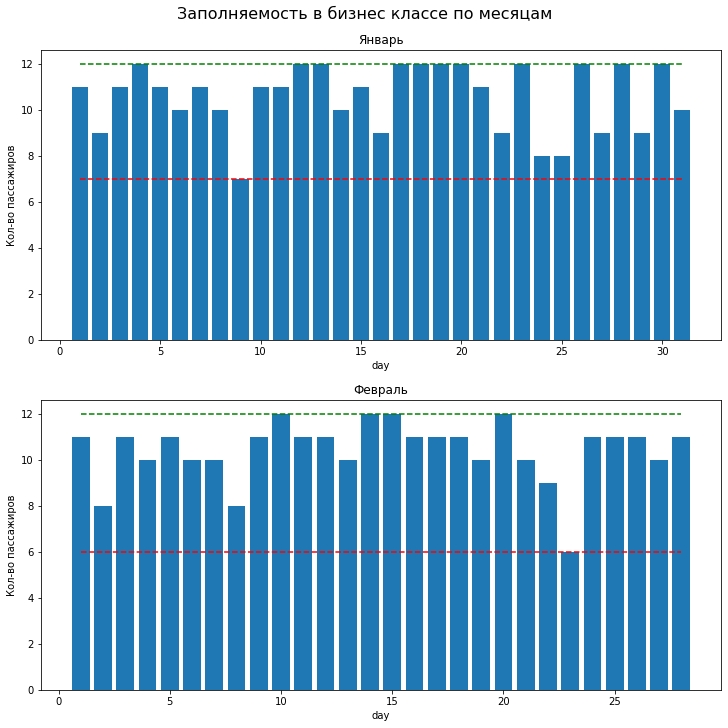

In [688]:
x = range(1, 32)
y = df_m.query('month_dep == 1').sort_values(by='day_dep')['bus_seats']
x1 = range(1, 29)
y1 = df_m.query('month_dep == 2').sort_values(by='day_dep')['bus_seats']
t = df['bussines_seats'].max()
fig, (ax1, ax2) = plt.subplots(
    2, 1, constrained_layout=True, sharey=True, figsize=(10, 10))
ax1.bar(x, y)
ax1.set_title('Январь')
ax1.set_xlabel('day')
ax1.set_ylabel('Кол-во пассажиров')
ax1.plot(x, [y.min() for i in x], '--', color='r')
ax1.plot(x, [t for i in x], '--', color='g')
ax2.bar(x1, y1)
ax2.set_xlabel('day')
ax2.set_title('Февраль')
ax2.set_ylabel('Кол-во пассажиров')
ax2.plot(x1, [y1.min() for i in x1], '--', color='r')
ax2.plot(x1, [t for i in x1], '--', color='g')
fig.suptitle('Заполняемость в бизнес классе по месяцам', fontsize=16)
print('Среднее кол-во пассажиров на рейс за январь :',
      round(df_m.query('month_dep == 1').sort_values(by='day_dep')['bus_seats'].mean()))
print('Рейсы с заполняемостью ниже среднего в январе', df_m.query(
    'month_dep == 1 & bus_seats < 11')['flight_id'].nunique())
print('Среднее кол-во пассажиров на рейс за февраль :',
      round(df_m.query('month_dep == 2').sort_values(by='day_dep')['bus_seats'].mean()))
print('Рейсы с заполняемостью ниже среднего в феврале', df_m.query(
    'month_dep == 2 & bus_seats < 10')['flight_id'].nunique())

Среднее кол-во пассажиров за январь : 103
Рейсы с заполняемостью ниже среднего в январе 16
Среднее кол-во пассажиров за февраль : 102
Рейсы с заполняемостью ниже среднего в феврале 16


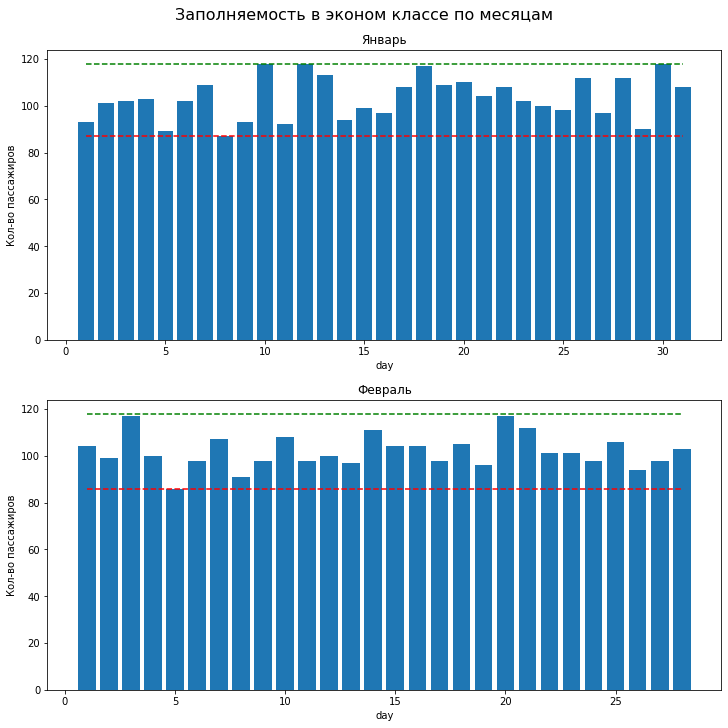

In [685]:
x = range(1,32)
y = df_m.query('month_dep == 1').sort_values(by='day_dep')['eco_seats']
x1 = range(1,29)
y1 = df_m.query('month_dep == 2').sort_values(by='day_dep')['eco_seats']
t = df['economy_seats'].max()
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharey=True,figsize=(10, 10))
ax1.bar(x, y)
ax1.set_title('Январь')
ax1.set_xlabel('day')
ax1.set_ylabel('Кол-во пассажиров')
ax1.plot(x,[y.min() for i in x], '--',color='r')
ax1.plot(x,[t for i in x], '--',color='g')
ax2.bar(x1, y1)
ax2.set_xlabel('day')
ax2.set_title('Февраль')
ax2.set_ylabel('Кол-во пассажиров')
ax2.plot(x1,[y1.min() for i in x1], '--',color='r')
ax2.plot(x1,[t for i in x1], '--',color='g')
fig.suptitle('Заполняемость в эконом классе по месяцам', fontsize=16)
print('Среднее кол-во пассажиров на рейс за январь :',
      round(df_m.query('month_dep == 1').sort_values(by='day_dep')['eco_seats'].mean()))
print('Рейсы с заполняемостью ниже среднего в январе', df_m.query(
    'month_dep == 1 & eco_seats < 103')['flight_id'].nunique())
print('Среднее кол-во пассажиров на рейс за февраль :',
      round(df_m.query('month_dep == 2').sort_values(by='day_dep')['eco_seats'].mean()))
print('Рейсы с заполняемостью ниже среднего в феврале', df_m.query(
    'month_dep == 2 & eco_seats < 102')['flight_id'].nunique())

Text(0.5, 0.98, 'Доля заполняемости по месяцам')

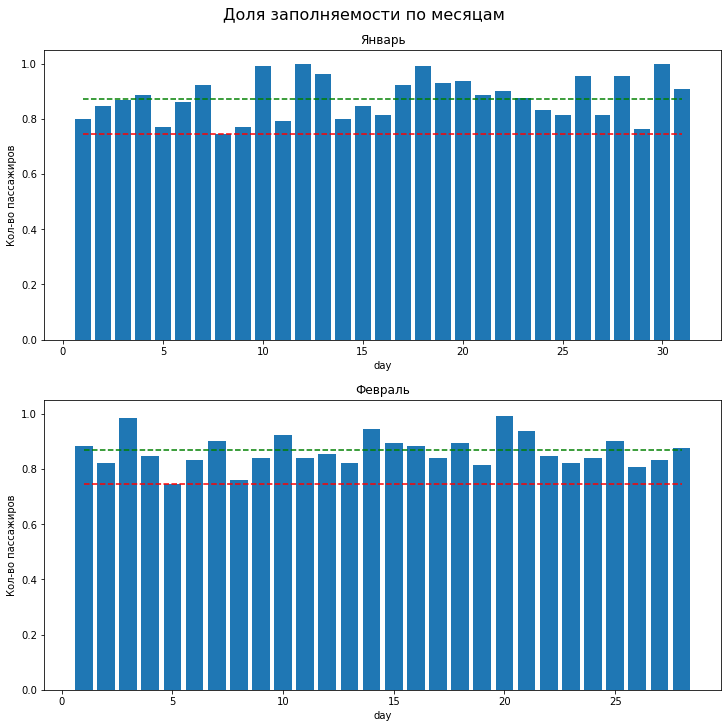

In [421]:
x = range(1,32)
y = df_m.query('month_dep == 1').sort_values(by='day_dep')['occupancy_fl']
x1 = range(1,29)
y1 = df_m.query('month_dep == 2').sort_values(by='day_dep')['occupancy_fl']
t = df_m['occupancy_fl'].mean()
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharey=True,figsize=(10, 10))
ax1.bar(x, y)
ax1.set_title('Январь')
ax1.set_xlabel('day')
ax1.set_ylabel('Кол-во пассажиров')
ax1.plot(x,[y.min() for i in x], '--',color='r')
ax1.plot(x,[t for i in x], '--',color='g')
ax2.bar(x1, y1)
ax2.set_xlabel('day')
ax2.set_title('Февраль')
ax2.set_ylabel('Кол-во пассажиров')
ax2.plot(x1,[y1.min() for i in x1], '--',color='r')
ax2.plot(x1,[t for i in x1], '--',color='g')
fig.suptitle('Доля заполняемости по месяцам', fontsize=16)

В среднем заполняемость по направлению Москва больше 80%, что говорит о востребованности перевозок по данному направлению.

### Рейсы с выручкой ниже рентабельности

In [743]:
df_problem[df_problem['city_arrival'] == 'Moscow'].sort_values(by=['month_dep','day_dep'])

,flight_id,flight_no,real_time,arrival_airport,air_arr_name,city_arrival,bus_seats,eco_seats,bus_amount,eco_amount,...,empty_bus,empty_eco,occupancy_fl,profit_margin,profit,fuel_consum_rub,fuel_ratio,bus_occup,eco_occup,loss
15,136202,PG0252,102,SVO,Sheremetyevo International Airport,Moscow,11.0,89.0,402600.0,1093000.0,...,1.0,29.0,0.769231,1527660.0,-32060.0,216108.386000,0.144496,0.916667,0.754237,32060.0
2,136122,PG0252,100,SVO,Sheremetyevo International Airport,Moscow,10.0,87.0,366000.0,1065000.0,...,2.0,31.0,0.746154,1527660.0,-96660.0,211870.966667,0.148058,0.833333,0.737288,96660.0
54,136464,PG0252,100,SVO,Sheremetyevo International Airport,Moscow,7.0,93.0,256200.0,1141800.0,...,5.0,25.0,0.769231,1527660.0,-129660.0,211870.966667,0.151553,0.583333,0.788136,129660.0
39,136366,PG0252,99,SVO,Sheremetyevo International Airport,Moscow,11.0,92.0,402600.0,1124800.0,...,1.0,26.0,0.792308,1527660.0,-260.0,209752.257000,0.137326,0.916667,0.779661,260.0
14,136185,PG0252,103,SVO,Sheremetyevo International Airport,Moscow,10.0,94.0,366000.0,1154000.0,...,2.0,24.0,0.800000,1527660.0,-7660.0,218227.095667,0.143570,0.833333,0.796610,7660.0
28,136282,PG0252,101,SVO,Sheremetyevo International Airport,Moscow,9.0,97.0,329400.0,1189400.0,...,3.0,21.0,0.815385,1527660.0,-8860.0,213989.676333,0.140894,0.750000,0.822034,8860.0
35,136345,PG0252,100,SVO,Sheremetyevo International Airport,Moscow,8.0,100.0,292800.0,1224800.0,...,4.0,18.0,0.830769,1527660.0,-10060.0,211870.966667,0.139609,0.666667,0.847458,10060.0
40,136383,PG0252,102,SVO,Sheremetyevo International Airport,Moscow,8.0,98.0,292800.0,1200400.0,...,4.0,20.0,0.815385,1527660.0,-34460.0,216108.386000,0.144728,0.666667,0.830508,34460.0
57,136485,PG0252,100,SVO,Sheremetyevo International Airport,Moscow,9.0,97.0,329400.0,1190600.0,...,3.0,21.0,0.815385,1527660.0,-7660.0,211870.966667,0.139389,0.750000,0.822034,7660.0
12,136178,PG0252,99,SVO,Sheremetyevo International Airport,Moscow,9.0,90.0,329400.0,1105200.0,...,3.0,28.0,0.761538,1527660.0,-93060.0,209752.257000,0.146210,0.750000,0.762712,93060.0


/Users/evgeny/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

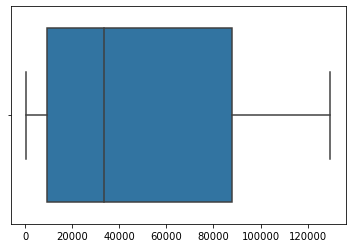

In [698]:
df_problem[df_problem['city_arrival'] == 'Moscow'].sort_values(by=['month_dep','day_dep'])
sns.boxplot(df_problem[df_problem['city_arrival'] == 'Moscow']['profit_margin']-df_problem[df_problem['city_arrival'] == 'Moscow']['total_amount_flight'])

### Наиболее убыточные рейсы

In [747]:
df_problem['loss'] = df_problem['profit_margin']- df_problem['total_amount_flight']
display(df_problem[df_problem['city_arrival'] == 'Moscow'].query('loss > 80000'))
print( 'Всего убытков :',df_problem[df_problem['city_arrival'] == 'Moscow'].query('loss > 80000')['loss'].sum())

<ipython-input-747-1cb422a2ba3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_problem['loss'] = df_problem['profit_margin']- df_problem['total_amount_flight']


,flight_id,flight_no,real_time,arrival_airport,air_arr_name,city_arrival,bus_seats,eco_seats,bus_amount,eco_amount,...,empty_bus,empty_eco,occupancy_fl,profit_margin,profit,fuel_consum_rub,fuel_ratio,bus_occup,eco_occup,loss
2,136122,PG0252,100,SVO,Sheremetyevo International Airport,Moscow,10.0,87.0,366000.0,1065000.0,...,2.0,31.0,0.746154,1527660.0,-96660.0,211870.966667,0.148058,0.833333,0.737288,96660.0
12,136178,PG0252,99,SVO,Sheremetyevo International Airport,Moscow,9.0,90.0,329400.0,1105200.0,...,3.0,28.0,0.761538,1527660.0,-93060.0,209752.257000,0.146210,0.750000,0.762712,93060.0
21,136250,PG0252,101,SVO,Sheremetyevo International Airport,Moscow,8.0,91.0,292800.0,1115000.0,...,4.0,27.0,0.761538,1527660.0,-119860.0,204270.150067,0.145099,0.666667,0.771186,119860.0
54,136464,PG0252,100,SVO,Sheremetyevo International Airport,Moscow,7.0,93.0,256200.0,1141800.0,...,5.0,25.0,0.769231,1527660.0,-129660.0,211870.966667,0.151553,0.583333,0.788136,129660.0


Всего убытков : 439240.0


Убыточные рейсы за январь-февраль 2017


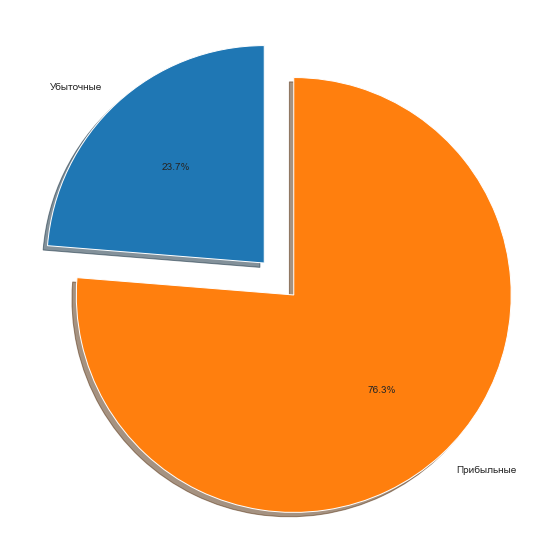

In [871]:
print('Убыточные рейсы за январь-февраль 2017')
labels = ['Убыточные','Прибыльные']
sizes = [14,59-14]
explode = (0.1, 0.1) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,radius=1)
plt.show()

Доля выручки Анапа - Москва по классам обслуживания за январь-февраль 2017


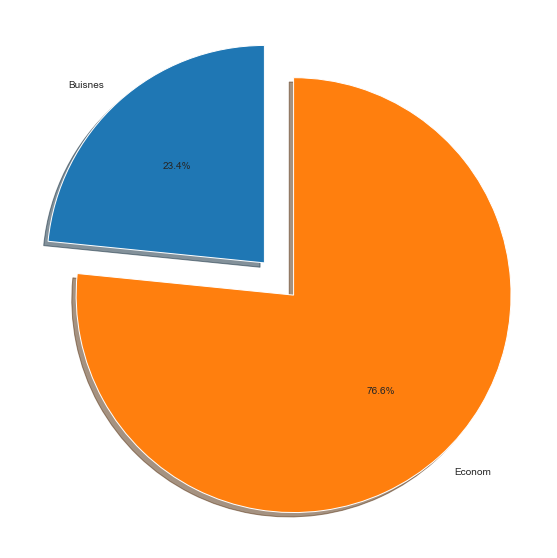

In [867]:
print('Доля выручки Анапа - Москва по классам обслуживания за январь-февраль 2017')
labels = ['Buisnes','Econom']
sizes = [df_m['bus_amount'].sum(),df_m['eco_amount'].sum()]
explode = (0.1, 0.1) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,radius=1)
plt.show()

In [755]:
df_final[df_final['city_arrival'] == 'Moscow']['total_in_flight'].sum() - 59*130

-996.0

In [756]:
df_final[df_final['city_arrival'] == 'Moscow']['bus_seats'].sum() - 59*12

-88.0

In [758]:
df_final[df_final['city_arrival'] == 'Moscow']['eco_seats'].sum() - 59*118

-908.0

In [881]:
# Список убыточных рейсов по ID и дате
df_problem[df_problem['city_arrival'] == 'Moscow'].sort_values(
    by=['month_dep', 'day_dep'])[['flight_id','month_dep', 'day_dep', 'day_name','loss']]

,flight_id,month_dep,day_dep,day_name,loss
15,136202,1,5,3,32060.0
2,136122,1,8,6,96660.0
54,136464,1,9,0,129660.0
39,136366,1,11,2,260.0
14,136185,1,14,5,7660.0
28,136282,1,16,0,8860.0
35,136345,1,24,1,10060.0
40,136383,1,25,2,34460.0
57,136485,1,27,4,7660.0
12,136178,1,29,6,93060.0


### Итог по Москве

1. За январь и февраль услугами авиакомпании по направлению Москва(Шереметьево), воспользовалось 6674 пассажиров, осуществленно 59 рейсов.
2. Рейсы осуществляются ежедневно самолетом модели Boeing 737-300 с максимальной загрузкой 130 пассажиров,средняя заполняемость 87%.
3. Общая выручка по направлению 20 682 600.0 руб
4. По относительной границе прибыльности рейса было выделено: убыточных рейсов 14 (23,7%), из них наиболее убыточных 4. Сумарный убыток составил 704 640 руб. Наиболее убточных рейсов 439 240 руб. Средняя заполняемость составила 79%, наиболее убыточных 76%   Основные потери пришлись от недопроданности билетов в эконом классе.
5. За январь и февраль было недопроданно 996 мест, 88 в бизнесс классе и 908 в экономе

### Белгород

In [873]:
df_b = df_final[df_final['city_arrival'] == 'Belgorod']

Среднее кол-во пассажиров на рейс за январь : 90
Рейсы с заполняемостью ниже среднего в январе 12
Среднее кол-во пассажиров на рейс за февраль : 90
Рейсы с заполняемостью ниже среднего в феврале 11


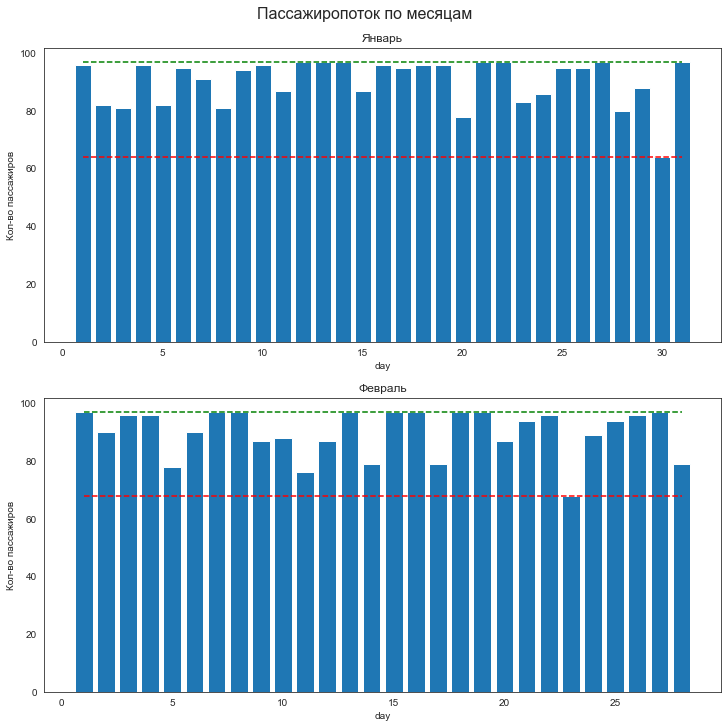

In [874]:
x = range(1,32)
y = df_b.query('month_dep == 1').sort_values(by='day_dep')['total_in_flight']
x1 = range(1,29)
y1 = df_b.query('month_dep == 2').sort_values(by='day_dep')['total_in_flight']
t = df_b['total_seats'].max()
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharey=True,figsize=(10, 10))
ax1.bar(x, y)
ax1.set_title('Январь')
ax1.set_xlabel('day')
ax1.set_ylabel('Кол-во пассажиров')
ax1.plot(x,[y.min() for i in x], '--',color='r')
ax1.plot(x,[t for i in x], '--',color='g')
ax2.bar(x1, y1)
ax2.set_xlabel('day')
ax2.set_title('Февраль')
ax2.set_ylabel('Кол-во пассажиров')
ax2.plot(x1,[y1.min() for i in x1], '--',color='r')
ax2.plot(x1,[t for i in x1], '--',color='g')
fig.suptitle('Пассажиропоток по месяцам', fontsize=16)
print('Среднее кол-во пассажиров на рейс за январь :',
      round(df_b.query('month_dep == 1').sort_values(by='day_dep')['total_in_flight'].mean()))
print('Рейсы с заполняемостью ниже среднего в январе', df_b.query(
    'month_dep == 1 & total_in_flight < 90')['flight_id'].nunique())
print('Среднее кол-во пассажиров на рейс за февраль :',
      round(df_b.query('month_dep == 2').sort_values(by='day_dep')['total_in_flight'].mean()))
print('Рейсы с заполняемостью ниже среднего в феврале', df_b.query(
    'month_dep == 2 & total_in_flight < 90')['flight_id'].nunique())

Среднее кол-во пассажиров на рейс за январь : 11
Рейсы с заполняемостью ниже среднего в январе 9
Среднее кол-во пассажиров на рейс за февраль : 11
Рейсы с заполняемостью ниже среднего в феврале 8


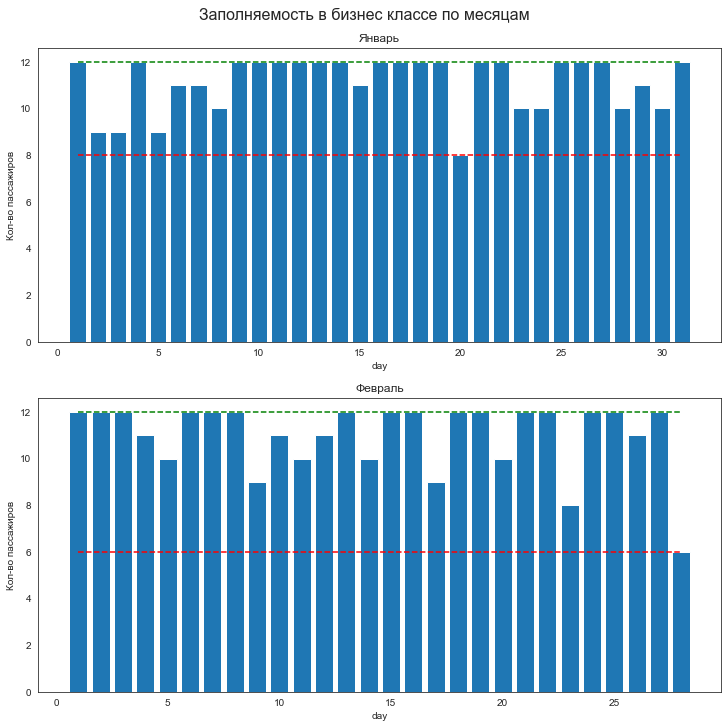

In [884]:
x = range(1,32)
y = df_b.query('month_dep == 1').sort_values(by='day_dep')['bus_seats']
x1 = range(1,29)
y1 = df_b.query('month_dep == 2').sort_values(by='day_dep')['bus_seats']
t = df_b['bus_seats'].max()
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharey=True,figsize=(10, 10))
ax1.bar(x, y)
ax1.set_title('Январь')
ax1.set_xlabel('day')
ax1.set_ylabel('Кол-во пассажиров')
ax1.plot(x,[y.min() for i in x], '--',color='r')
ax1.plot(x,[t for i in x], '--',color='g')
ax2.bar(x1, y1)
ax2.set_xlabel('day')
ax2.set_title('Февраль')
ax2.set_ylabel('Кол-во пассажиров')
ax2.plot(x1,[y1.min() for i in x1], '--',color='r')
ax2.plot(x1,[t for i in x1], '--',color='g')
fig.suptitle('Заполняемость в бизнес классе по месяцам', fontsize=16)
print('Среднее кол-во пассажиров на рейс за январь :',
      round(df_b.query('month_dep == 1').sort_values(by='day_dep')['bus_seats'].mean()))
print('Рейсы с заполняемостью ниже среднего в январе', df_b.query(
    'month_dep == 1 & bus_seats < 11')['flight_id'].nunique())
print('Среднее кол-во пассажиров на рейс за февраль :',
      round(df_b.query('month_dep == 2').sort_values(by='day_dep')['bus_seats'].mean()))
print('Рейсы с заполняемостью ниже среднего в феврале', df_b.query(
    'month_dep == 2 & bus_seats < 11')['flight_id'].nunique())

Среднее кол-во пассажиров на рейс за январь : 79
Рейсы с заполняемостью ниже среднего в январе 12
Среднее кол-во пассажиров на рейс за февраль : 79
Рейсы с заполняемостью ниже среднего в феврале 13


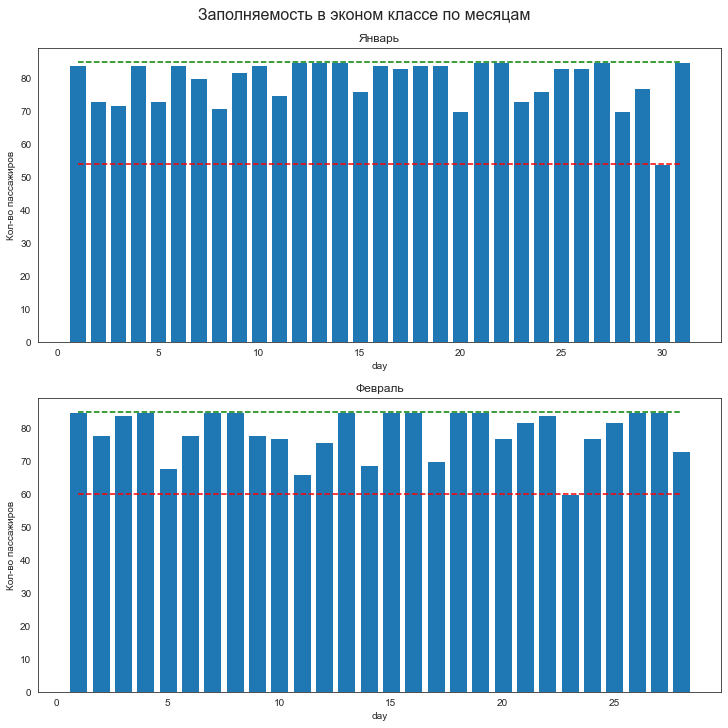

In [878]:
x = range(1,32)
y = df_b.query('month_dep == 1').sort_values(by='day_dep')['eco_seats']
x1 = range(1,29)
y1 = df_b.query('month_dep == 2').sort_values(by='day_dep')['eco_seats']
t = df_b['eco_seats'].max()
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharey=True,figsize=(10, 10))
ax1.bar(x, y)
ax1.set_title('Январь')
ax1.set_xlabel('day')
ax1.set_ylabel('Кол-во пассажиров')
ax1.plot(x,[y.min() for i in x], '--',color='r')
ax1.plot(x,[t for i in x], '--',color='g')
ax2.bar(x1, y1)
ax2.set_xlabel('day')
ax2.set_title('Февраль')
ax2.set_ylabel('Кол-во пассажиров')
ax2.plot(x1,[y1.min() for i in x1], '--',color='r')
ax2.plot(x1,[t for i in x1], '--',color='g')
fig.suptitle('Заполняемость в эконом классе по месяцам', fontsize=16)
print('Среднее кол-во пассажиров на рейс за январь :',
      round(df_b.query('month_dep == 1').sort_values(by='day_dep')['eco_seats'].mean()))
print('Рейсы с заполняемостью ниже среднего в январе', df_b.query(
    'month_dep == 1 & eco_seats < 79')['flight_id'].nunique())
print('Среднее кол-во пассажиров на рейс за февраль :',
      round(df_b.query('month_dep == 2').sort_values(by='day_dep')['eco_seats'].mean()))
print('Рейсы с заполняемостью ниже среднего в феврале', df_b.query(
    'month_dep == 2 & eco_seats < 79')['flight_id'].nunique())

Text(0.5, 0.98, 'Доля заполняемости по месяцам')

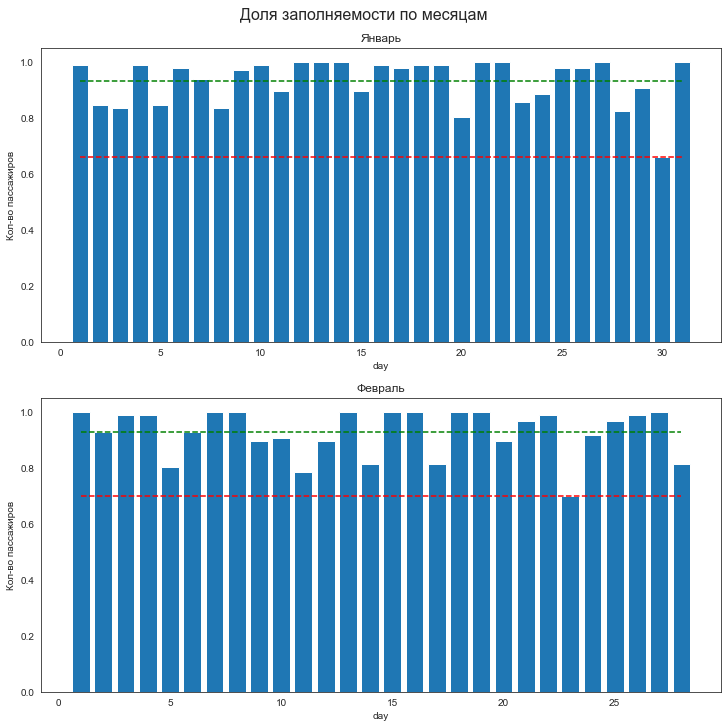

In [877]:
x = range(1,32)
y = df_b.query('month_dep == 1').sort_values(by='day_dep')['occupancy_fl']
x1 = range(1,29)
y1 = df_b.query('month_dep == 2').sort_values(by='day_dep')['occupancy_fl']
t = df_b['occupancy_fl'].mean()
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharey=True,figsize=(10, 10))
ax1.bar(x, y)
ax1.set_title('Январь')
ax1.set_xlabel('day')
ax1.set_ylabel('Кол-во пассажиров')
ax1.plot(x,[y.min() for i in x], '--',color='r')
ax1.plot(x,[t for i in x], '--',color='g')
ax2.bar(x1, y1)
ax2.set_xlabel('day')
ax2.set_title('Февраль')
ax2.set_ylabel('Кол-во пассажиров')
ax2.plot(x1,[y1.min() for i in x1], '--',color='r')
ax2.plot(x1,[t for i in x1], '--',color='g')
fig.suptitle('Доля заполняемости по месяцам', fontsize=16)

In [482]:
df_problem[df_problem['city_arrival'] == 'Belgorod'].sort_values(by=['month_dep','day_dep'])

,flight_id,flight_no,month_dep,day_dep,day_name,real_time,arrival_airport,city_arrival,bus_seats,com_seats,...,total_seats,total_in_flight,empty_bus,empty_com,empty_eco,occupancy_fl,fuel_consum_rub,fuel_ratio,profit_margin,loss
107,136887,PG0480,1,20,Friday,49,EGO,Belgorod,8.0,0.0,...,97,78.0,4.0,0.0,15.0,0.804124,67880.198167,0.114046,619893.0,24693.0
68,136642,PG0480,1,30,Monday,49,EGO,Belgorod,10.0,0.0,...,97,64.0,2.0,0.0,31.0,0.659794,67880.198167,0.127835,619893.0,88893.0
111,136922,PG0480,2,11,Saturday,50,EGO,Belgorod,10.0,0.0,...,97,76.0,2.0,0.0,19.0,0.783505,66119.431667,0.108785,619893.0,12093.0
65,136620,PG0480,2,17,Friday,49,EGO,Belgorod,9.0,0.0,...,97,79.0,3.0,0.0,15.0,0.814433,64797.043033,0.105619,619893.0,6393.0
93,136807,PG0480,2,23,Thursday,50,EGO,Belgorod,8.0,0.0,...,97,68.0,4.0,0.0,25.0,0.701031,66119.431667,0.124519,619893.0,88893.0
100,136844,PG0480,2,28,Tuesday,50,EGO,Belgorod,6.0,0.0,...,97,79.0,6.0,0.0,12.0,0.814433,66119.431667,0.114970,619893.0,44793.0


Убыточные рейсы в % январь-февраль 2017


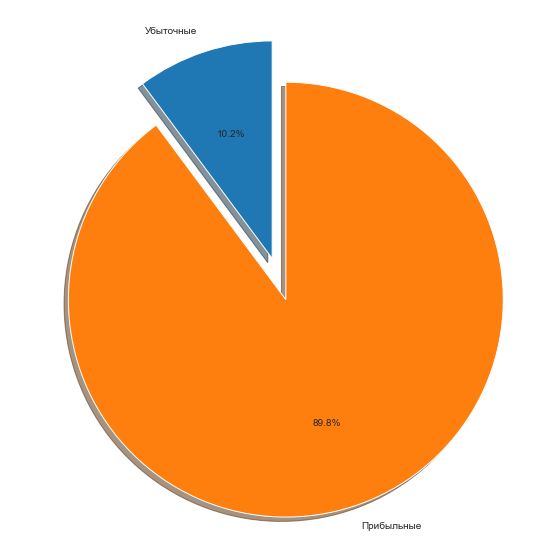

In [882]:
print('Убыточные рейсы в % январь-февраль 2017')
labels = ['Убыточные','Прибыльные']
sizes = [6,59-6]
explode = (0.1, 0.1) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,radius=1)
plt.show()

Доля выручки Анапа - Белгород по классам обслуживания за январь-февраль 2017


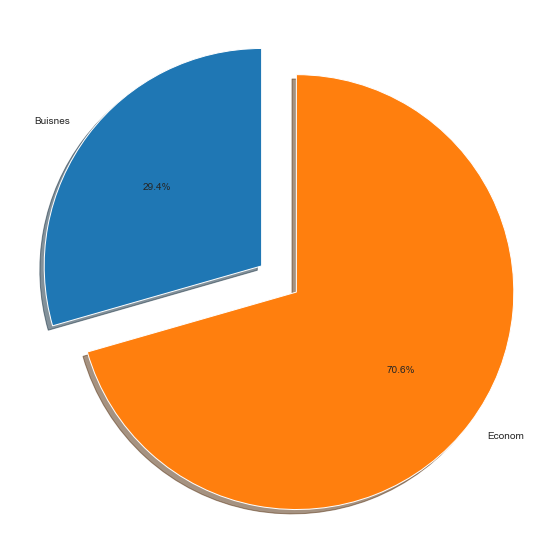

In [879]:
print('Доля выручки Анапа - Белгород по классам обслуживания за январь-февраль 2017')
labels = ['Buisnes','Econom']
sizes = [df_b['bus_amount'].sum(),df_b['eco_amount'].sum()]
explode = (0.1, 0.1) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,radius=1)
plt.show()

In [764]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 59 to 117
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            59 non-null     int64  
 1   flight_no            59 non-null     object 
 2   month_dep            59 non-null     int64  
 3   day_dep              59 non-null     int64  
 4   day_name             59 non-null     object 
 5   real_time            59 non-null     int64  
 6   arrival_airport      59 non-null     object 
 7   city_arrival         59 non-null     object 
 8   bus_seats            59 non-null     float64
 9   com_seats            59 non-null     float64
 10  eco_seats            59 non-null     float64
 11  total_amount_flight  59 non-null     float64
 12  model                59 non-null     object 
 13  bussines_seats       59 non-null     int64  
 14  comfort_seats        59 non-null     int64  
 15  economy_seats        59 non-null     int

In [885]:
df_problem[df_problem['city_arrival'] == 'Belgorod'].sort_values(
    by=['month_dep', 'day_dep'])[['flight_id','month_dep', 'day_dep', 'day_name','loss']]

,flight_id,month_dep,day_dep,day_name,loss
107,136887,1,20,4,24693.0
68,136642,1,30,0,88893.0
111,136922,2,11,5,12093.0
65,136620,2,17,4,6393.0
93,136807,2,23,3,88893.0
100,136844,2,28,1,44793.0


1. За январь и февраль услугами авиакомпании по направлению Белгород (Spichenkovo), воспользовалось 5321 пассажиров, осуществленно 59 рейсов.
2. Рейсы осуществляются ежедневно самолетом модели Sukhoi Superjet-100 с максимальной загрузкой 97 пассажиров, средняя заполняемость 93%.
3. Общая выручка по направлению 41 915 700.0 руб
4. По относительной границе прибыльности рейса было выделено: убыточных рейсов 6 (10,2%). Сумарный убыток составил 265 758.0 руб. Средняя заполняемость убыточных рейсов составила 76%. Основные потери пришлись от недопроданности билетов в эконом классе.
5. За январь и февраль было недопроданно 402 места, 55 в бизнесс классе и 347 в экономе.
6. Нужно отметить, что было совершено два рейса с заполняемостью 66% и 70% (30-го января и 23-го февраля)




In [842]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 117
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            118 non-null    int64  
 1   flight_no            118 non-null    object 
 2   month_dep            118 non-null    int64  
 3   day_dep              118 non-null    int64  
 4   day_name             118 non-null    int64  
 5   real_time            118 non-null    int64  
 6   arrival_airport      118 non-null    object 
 7   city_arrival         118 non-null    object 
 8   bus_seats            118 non-null    float64
 9   bus_occup            118 non-null    float64
 10  eco_seats            118 non-null    float64
 11  eco_occup            118 non-null    float64
 12  model                118 non-null    object 
 13  total_seats          118 non-null    int64  
 14  total_in_flight      118 non-null    float64
 15  empty_bus            118 non-null    flo

In [793]:
df_final.to_csv('final_dataset.csv', index=False)